# Differential UWB model

The ideas behind this model improve on the previous ones by adding a second UWB transceiver to the system. The idea is to be able to measure heading directly from the UWB beacon.

Assumptions:

* Robot moves in the 2D plane
* Gyro in the yaw axis
* Gyroscope has constant bias ($b_\omega$) and random noise.
* UWB receivers are separated by a fixed distance $d$.

As previously, the state of the robot is:

\begin{equation}
\mathbf{x} = \begin{pmatrix}
    x\\
    y\\
    \dot{x}\\
    \dot{y}\\
    \theta\\
    b_{\omega}
    \end{pmatrix}
\end{equation}



In [1]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
sp.init_printing()

# defines useful variables
x, y, xdot, ydot, theta, b_omega, d = sp.symbols('x y v_x v_y theta b_{\omega} d')
state = sp.Matrix([x, y, xdot, ydot, theta, b_omega])
dt = sp.symbols('Delta_t')

# Prediction step

The prediction step is the same as in the gyro integrating model.

In [2]:
a_x, a_y, omega = sp.symbols('a_x a_y omega') # in body frame
u = [a_x, a_y, omega]
dx = sp.Matrix([xdot,
                ydot,
                sp.cos(theta) * a_x - sp.sin(theta) * a_y,
                sp.sin(theta) * a_x + sp.cos(theta) * a_y,
                omega - b_omega,
                0])
g = state + dt * dx

## Measurement step

For the measurement, the UWB system gives us the distance $d$ to a beacon.
The beacon's position $\mathbf{b}$ is known and assumed to be fixed.

We first compute the position of each UWB receiver. Receiver $n$ is assumed to be at position $\mathbf{x}_{UWB,n}^R$ in robot frame.

\begin{equation}
\mathbf{x}_{UWB,n}^W = \mathbf{x}_{robot}^W + \begin{pmatrix}
\cos \theta & - \sin \theta \\
\sin \theta & \cos \theta
\end{pmatrix} \mathbf{x}_{UWB,n}^R
\end{equation}

Then the measurement model is:

\begin{equation}
h_n(\mathbf{x}, \mathbf{b}) = \sqrt{(x_{UWB,n}^W - b_x)^2 + (y_{UWB,n}^W - b_y)^2}
\end{equation}

In [3]:
b_x, b_y = sp.symbols('b_x b_y') # beacon position
uwb_x, uwb_y = sp.symbols('x_{UWB} y_{UWB}')
uwb_pos_robot = sp.Matrix([uwb_x, uwb_y])
uwb_pos_world = sp.Matrix([x, y]) + sp.Matrix([[sp.cos(theta), -sp.sin(theta)], [sp.sin(theta), sp.cos(theta)]]) @ uwb_pos_robot
h_b = sp.sqrt((uwb_pos_world[0] - b_x)**2 + (uwb_pos_world[1] - b_y)**2)
#h_b = h_b.replace(uwb_x, 0).replace(uwb_y, 0)

In [4]:
# Put it in a matrix to conform with EKF framework
h_b = sp.Matrix([h_b])

## EKF implementation

As before, we derive the calculation using Sympy:

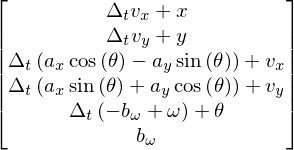

In [5]:
g

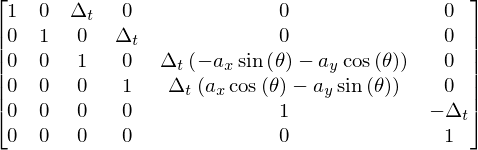

In [6]:
g.jacobian(state)

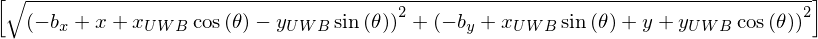

In [7]:
h_b

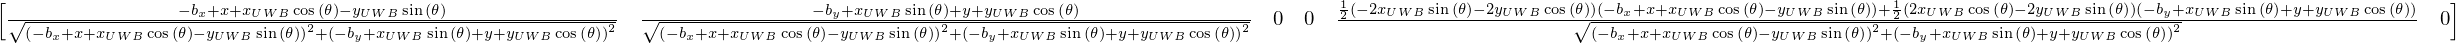

In [8]:
h_b.jacobian(state)

## Simulation

In [9]:
f = 200 # Hz, sample rate of the filter
g_num = sp.lambdify([state, u], g.replace(dt, 1/f), 'numpy')
G_num = sp.lambdify([state, u], g.jacobian(state).replace(dt, 1/f), 'numpy')
h_num = sp.lambdify([[b_x, b_y], [uwb_x, uwb_y], state], h_b, 'numpy')
H_num = sp.lambdify([[b_x, b_y], [uwb_x, uwb_y], state], h_b.jacobian(state), 'numpy')

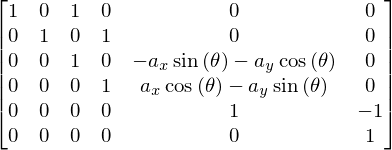

In [10]:
# quick sanity checks
s = np.array([1, 1, 0, 0, 3.14, 0])
h_num((0, 0), (1, 1), s)
u = np.array([0, 0 ,0])
g_num(s, u)
g.jacobian(state).replace(dt, 1)

In [11]:
# Defines the kalman filter
import functools
import ekf

# Create a dummy variance model
R = np.diag([0.1, # pos
             0.1,
             1e-4, # speed
             1e-4,
             1e-4, # angle
             1e-4  # bias
            ])
Q = np.diag([20]) # distance measurement

predictor = ekf.Predictor(g_num, G_num, R)

BEACON_POS = [
    (-1.5, 0),
    (1.5, 1),
    (1.5, -1),
]


d = 0.1# Distance between receivers, in meters
UWB_POS = [
    (-d / 2, 0),
    ( d / 2, 0)
]
  
correctors = [
    ekf.Corrector(functools.partial(h_num, pos, uwb_pos),
                  functools.partial(H_num, pos, uwb_pos),
                  Q
                 )
for pos in BEACON_POS for uwb_pos in UWB_POS]

In [12]:
# Runs the kalman filter on a circular trajectory
import trajectories

f_uwb = 10 # Update frequency for the UWB beacons


bias = np.deg2rad(5) # rad / s
bias_var = np.deg2rad(3.3)

mu = np.array([0, 0, 0, 0.1, 0, bias]) # initial state
sigma = np.diag([1e-1, 1e-1, # pos
                 1e-3, 1e-3, # speed
                 1e-1, # angle
                 bias_var,
                ])

angle, angle_estimated = [], []
x, xhat = [], []
y, yhat = [], []
acc = []
ts = []

for i, p in zip(range(10000), trajectories.generate_circular_traj(1, np.deg2rad(10), 1/f)):

    # add noise & bias to the measurements
    acc = [p.acc[0], p.acc[1]] + np.random.normal(0, 0.2, 2)
    omega = p.omega + np.random.normal(bias, np.sqrt(bias_var))
    
    # feeds the input into Kalman
    filter_input = np.array([acc[0], acc[1], omega])

    mu, sigma = predictor(mu, sigma, filter_input)
    
    # If we received a radio update, feed it into the EKF
    if i % (f // f_uwb) == 0:
        for corrector in correctors:
            z = corrector.h(np.array([p.pos[0], p.pos[1], 0, 0, p.theta, 0]))
            z += np.random.normal(0, 0.03)
            mu, sigma = corrector(mu, sigma, z)
            
    
    # Saves the data
    ts.append(p.timestamp)
    angle.append(p.theta)
    angle_estimated.append(mu[4])
    x.append(p.pos[0])
    xhat.append(mu[0])
    y.append(p.pos[1])
    yhat.append(mu[1])

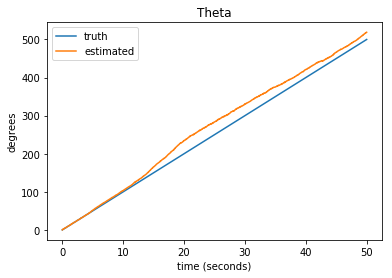

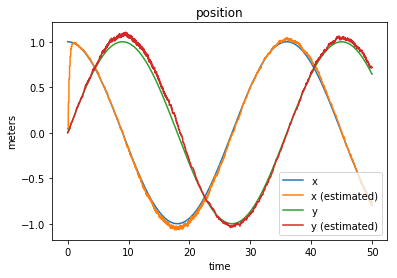

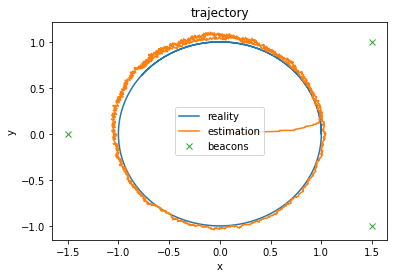

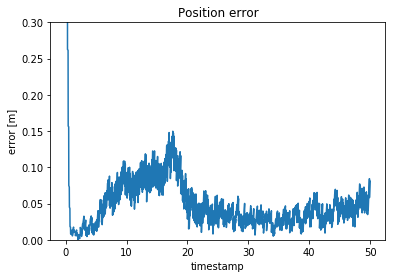

In [13]:
# Plot various results
plt.plot(ts, np.degrees(angle))
plt.plot(ts, np.degrees(angle_estimated))
plt.xlabel('time (seconds)')
plt.ylabel('degrees')
plt.legend(['truth', 'estimated'])
plt.title('Theta')
plt.show()

plt.plot(ts, x)
plt.plot(ts, xhat)
plt.plot(ts, y)
plt.plot(ts, yhat)
plt.xlabel('time')
plt.ylabel('meters')
plt.title('position')
plt.legend(['x', 'x (estimated)', 'y', 'y (estimated)'])
plt.show()

plt.plot(x, y)
plt.plot(xhat, yhat)
plt.plot([x for x, y in BEACON_POS],[y for x, y in BEACON_POS], 'x')
plt.legend(('reality', 'estimation', 'beacons'))
plt.title('trajectory')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.plot(ts, [np.sqrt((x-xh)**2+(y-yh)**2) for x,xh,y,yh in zip(x, xhat,y,yhat)])
plt.xlabel('timestamp')
plt.ylabel('error [m]')
plt.ylim(0, 0.3)
plt.title('Position error')
plt.show()